# Implicit Regularisation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


## Dropout

เอา neuron บางส่วนใน input หรือ hidden layer ออก

<img src="../images/dropout.png" width="400" /><br />

## Batch normalisation

Normalise output จาก neuron ก่อนหรือหลังผ่าน activation function ก็ได้ (มักจะทำหลังผ่าน activation function)

<img src="../images/batch_normalisation.png" width="400" /><br />


In [4]:
# Modify the LeNet-5 network to include dropout and batch normalisation
class LeNet5drbn(nn.Module):
    """Class of the LeNet-5 model with dropout and batch normalisation."""
    def __init__(self):
        super(LeNet5drbn, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.s2_bn = nn.BatchNorm2d(6)
        # self.s2_dr = nn.Dropout2d(p=0.2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # self.c3_bn = nn.BatchNorm2d(16)
        self.c3_dr = nn.Dropout2d(p=0.5)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*5*5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2_bn(self.s2(x)))
        # x = self.s2_dr(x)
        # x = self.act(self.c3_bn(self.c3(x)))
        x = self.act(self.c3(x))
        x = self.c3_dr(x)
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        return self.output(x)

In [5]:
x = torch.randn((1, 1, 28, 28)).to(device)
model = LeNet5drbn().to(device)
y = model(x)
print(y)
summ = summary(model, (1, 28, 28))

tensor([[-0.0621, -0.0102, -0.1107, -0.0155,  0.0070,  0.0913, -0.1564,  0.1325,
          0.0348, -0.0533]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
       BatchNorm2d-4            [-1, 6, 14, 14]              12
              ReLU-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              ReLU-7           [-1, 16, 10, 10]               0
         Dropout2d-8           [-1, 16, 10, 10]               0
         MaxPool2d-9             [-1, 16, 5, 5]               0
             ReLU-10             [-1, 16, 5, 5]               0
           Linear-11                  [-1, 120]          48,120
             ReLU-12           

In [6]:
# Download the MNIST dataset
train_set = MNIST("../data", download=True, train=True)
test_set = MNIST("../data", download=True, train=False)

In [7]:
# Split the data
shuffler = StratifiedShuffleSplit(
    n_splits=1, test_size=0.1, random_state=42
).split(train_set.train_data, train_set.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [8]:
# Convert the tensor to a floating-point data type
train_data_tensor = train_set.train_data.to(torch.float32)
# Calculate min, max, mean and std
min_value = train_data_tensor.min()
max_value = train_data_tensor.max()
mean = torch.mean(train_data_tensor/255)
std = torch.std(train_data_tensor/255)
print(f"min = {min_value}\nmax = {max_value}\nmean = {mean}\nstd = {std}")

min = 0.0
max = 255.0
mean = 0.13066047430038452
std = 0.30810782313346863


In [9]:
# Standardise the data
standardise = lambda X: ((X/255)-mean)/std
X_train = standardise(train_set.train_data[indices[0]].float())
y_train = train_set.train_labels[indices[0]]
X_val = standardise(train_set.train_data[indices[1]].float())
y_val = train_set.train_labels[indices[1]]
X_test = standardise(test_set.test_data.float())
y_test = test_set.test_labels

In [10]:
# Create the TensorDatasets containing train, validation and test sets
train_set = TensorDataset(X_train, y_train.long())
val_set = TensorDataset(X_val, y_val.long())
test_set = TensorDataset(X_test, y_test.long())

In [11]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()
    avg_train_loss = train_loss/len(data_loader.dataset)
    avg_train_accuracy = train_accuracy/len(data_loader.dataset)
    return avg_train_loss, avg_train_accuracy

def validate(model, criterion, data_loader):
    model.eval()
    val_loss, val_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            loss = criterion(a2, y)
            val_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            val_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    avg_val_loss = val_loss/len(data_loader.dataset)
    avg_val_accuracy = val_accuracy/len(data_loader.dataset)
    return avg_val_loss, avg_val_accuracy

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    return np.concatenate(ys, 0), np.concatenate(y_preds, 0)

In [12]:
# Choose the hyperparameter of our network
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [13]:
set_seed(seed)
model = LeNet5drbn().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [14]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [15]:
# Train and validate the network and plot its learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy
set_seed(seed)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, val_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

KeyboardInterrupt: 

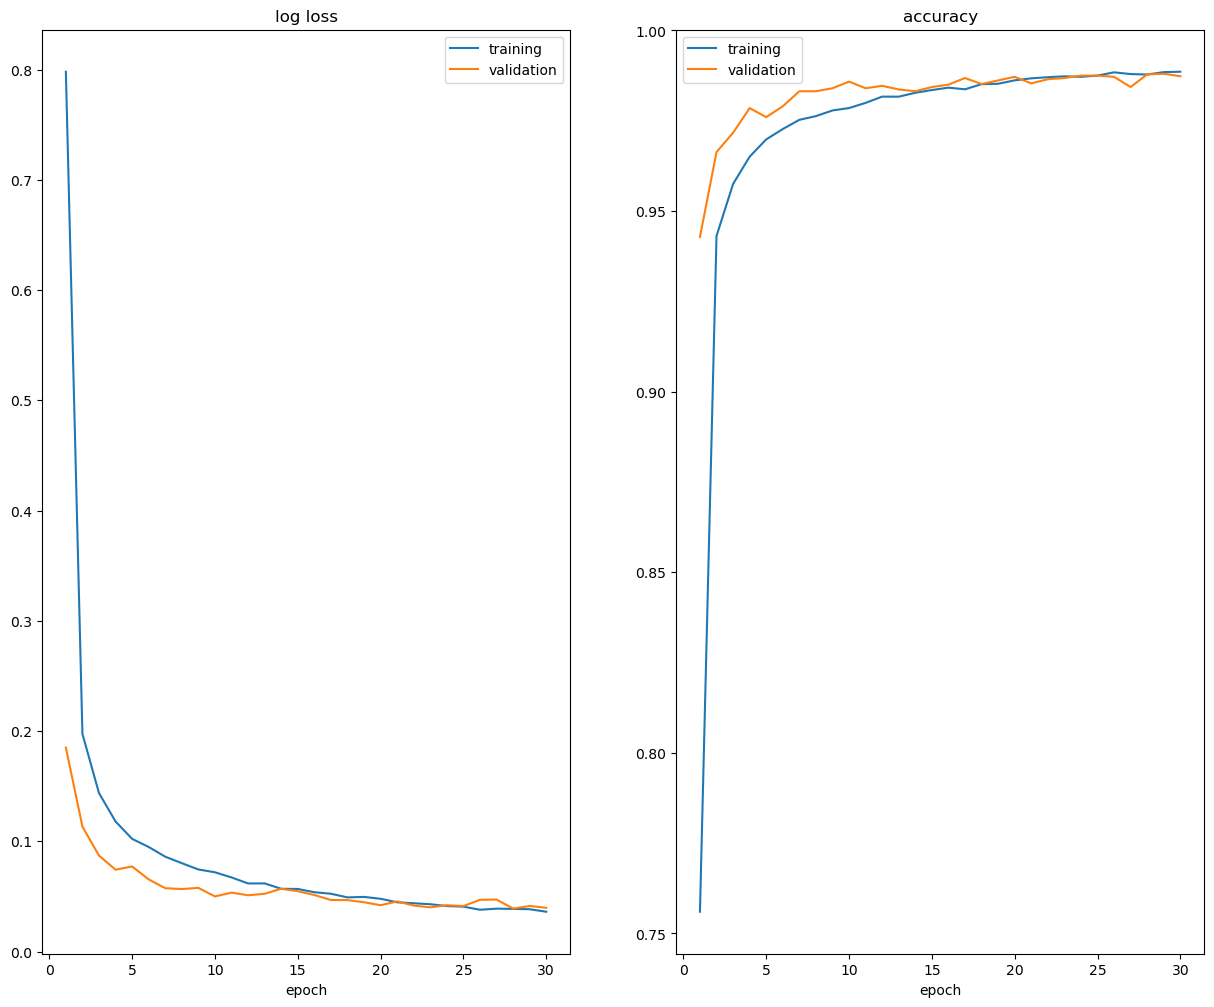

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].plot(range(1, n_epochs+1), train_losses, label="training")
axes[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axes[0].set(title="log loss", xlabel="epoch")
axes[0].legend()
axes[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axes[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axes[1].set(title="accuracy", xlabel="epoch")
axes[1].legend();

In [17]:
# Use the validation set to predict labels
ys, y_preds, = evaluate(model, val_loader)
pd.DataFrame({"True": ys, "Predicted": y_preds})

,True,Predicted
0,1,1
1,9,9
2,3,3
3,4,4
4,6,6
...,...,...
5995,4,4
5996,1,1
5997,5,5
5998,0,0


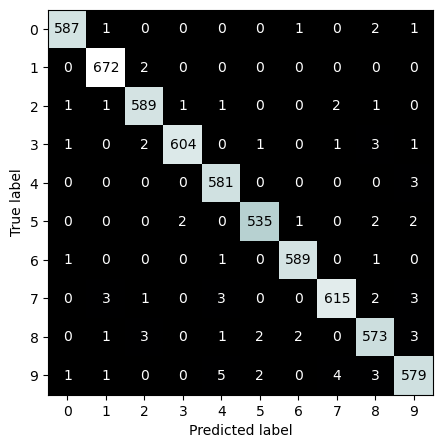

In [18]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(ys, y_preds, ax=ax, colorbar=False, cmap='bone');

## Data augmentation

เพิ่มปริมาณข้อมูลใน dataset โดยสร้างข้อมูลใหม่จากข้อมูลที่มีใน dataset นั้น

สำหรับ image dataset วิธีการที่ทำได้ เช่น หมุนภาพ เลื่อนภาพ สะท้อนภาพ crop ภาพ zoom ภาพ เพิ่ม noise ปรับความสว่าง เป็นต้น

<img src="../images/data_augmentation.png" width="500" /><br />

<a href="">Albumentation</a> เป็น library สำหรับทำ data augmentation ที่ทันสมัยที่สุดอันหนึ่ง


In [19]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Parameters
        ----------
        data : torch.Tensor
        
            A tensor containing the data, e.g., images.
            
        targets : torch.Tensor
        
            A tensor containing all the labels.
            
        transform : callable (optional)
        
            Transform to be applied on a sample.

        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [21]:
# Create a transform for the training set
train_transform = Compose([
    ToPILImage(),  # PIL is useful for opening, manipulating, and saving many different image file formats.
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[mean], std=[std]),
])

# Create a transform for validation and test sets
# We only want to normalize our images, because they are already tensors
val_test_transform = Compose([
    Normalize(mean=[mean], std=[std])
])

In [24]:
# Prepare training, validation, and test sets from CustomImageTensorDataset

# re-download MNIST
train_set = MNIST("../data", download=True, train=True)
test_set = MNIST("../data", download=True, train=False)
# Train-validation split
X_train = train_set.data[indices[0]]
y_train = train_set.targets[indices[0]]
X_val = train_set.data[indices[1]]
y_val = train_set.targets[indices[1]]
# Create custom training, validation, and test sets
train_set = CustomImageTensorDataset(X_train, y_train, transform=train_transform)
val_set = CustomImageTensorDataset(X_val, y_val, transform=val_test_transform)
test_set = CustomImageTensorDataset(X_test, y_test, transform=val_test_transform)
# Check the amount of data
print(train_set.__len__())
print(val_set.__len__())
print(test_set.__len__())

54000
6000
10000


In [25]:
class LeNet5(nn.Module):
    """Class of the LeNet-5 model."""
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*5*5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        return self.output(x)

In [26]:
# Train and validate the network and plot its learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, val_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

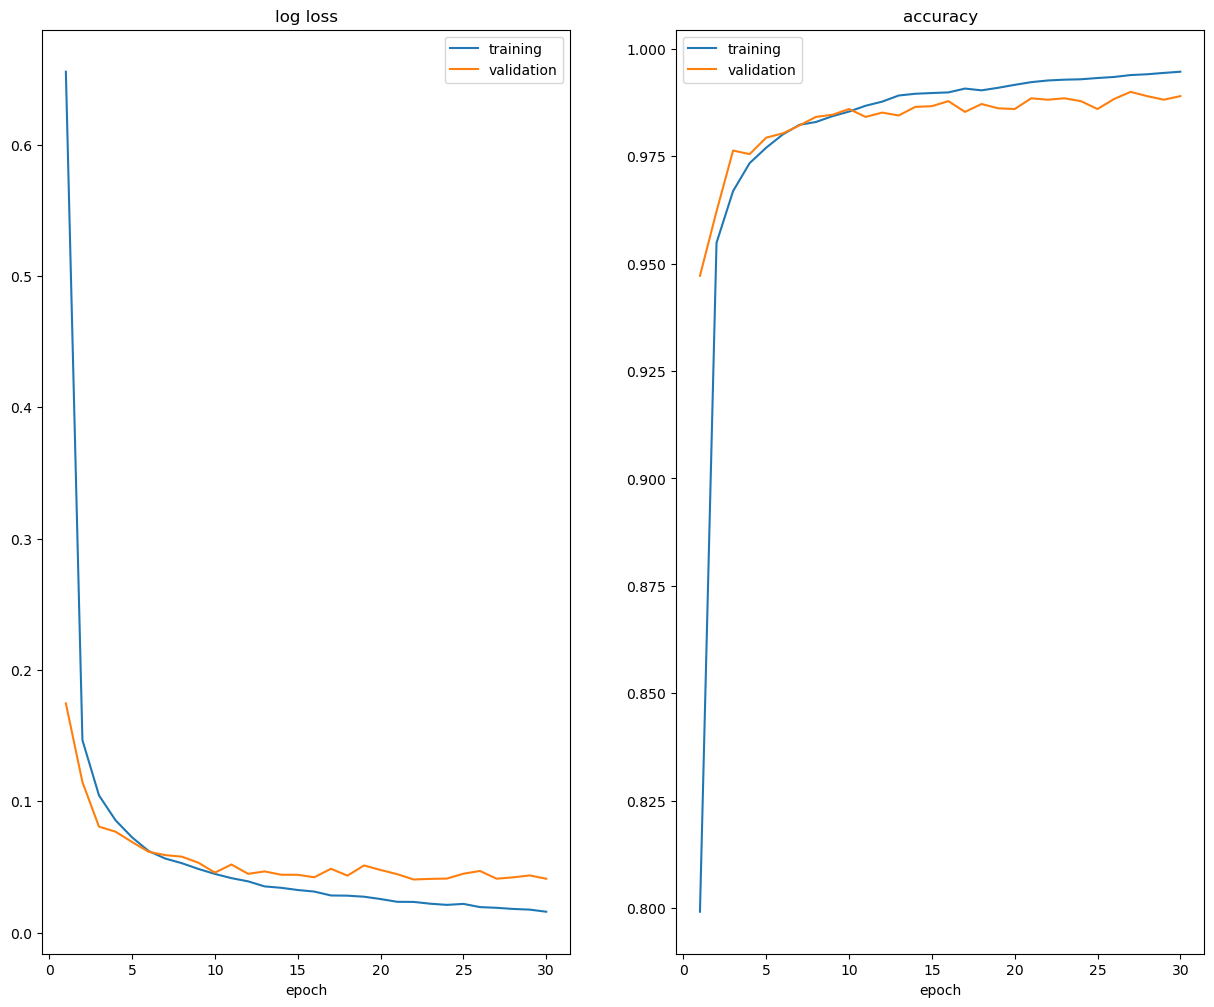

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].plot(range(1, n_epochs+1), train_losses, label="training")
axes[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axes[0].set(title="log loss", xlabel="epoch")
axes[0].legend()
axes[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axes[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axes[1].set(title="accuracy", xlabel="epoch")
axes[1].legend();

In [28]:
# Use the validation set to predict labels
ys, y_preds, = evaluate(model, val_loader)
pd.DataFrame({"True": ys, "Predicted": y_preds})

,True,Predicted
0,1,1
1,9,9
2,3,3
3,4,4
4,6,6
...,...,...
5995,4,4
5996,1,1
5997,5,5
5998,0,0


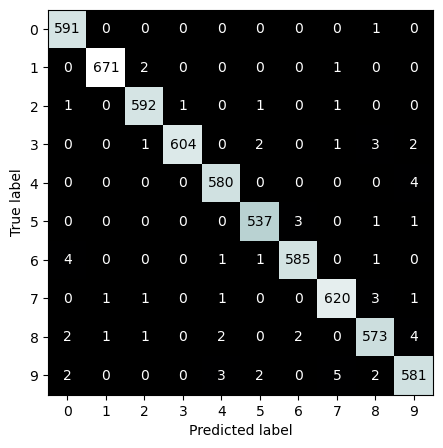

In [29]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(ys, y_preds, ax=ax, colorbar=False, cmap='bone');